In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021) and the empirical evaluation follows https://migariane.github.io/TMLE.nb.html

$\psi(P_0) = \mathbb{E}[\mathbb{E}[Y|X=1, Z]]$  is our target estimand - it is the potential outcome mean, i.e. the outcome $Y$ under treatment $X=1$ given covariates $Z$.

i.e. $$\psi(P_0) = \int y f(y|1,z)f(z) dy dz$$

Which is the statistical estimand of the mean of $Y^1$ (the quantity is identifiable).

If we assume the distribution from which the densities $f$ derive has been perturbed by a point mass at $(\tilde x, \tilde y, \tilde z)$ then:

$$\psi(P_0) = \int y f_t(y|1,z)f_t(z) dy dz$$

$$ = \int y \frac{f_t(y,1,z)f_t(z)}{f_t(1,z)} dy dz$$

Under the 'parametric submodel' $$P_t = t\delta_x(\tilde x) + (1-t)P_o$$ and where $\delta_x(\tilde x)$ denotes the Dirac delta function s.t. it gives the density of a point mass at $\tilde x$, is zero everywhere else, and integrates to 1.

For our densities we therefore have that:

$$f_t(x,y,z) =  t \delta_{x,y,z}(\tilde x, \tilde y, \tilde z) +  (1-t)f(x,y,z)$$

and, equivalently for $f_t(z)$ and $f_t(1,z)$.

Following the derivation in the paper, the efficient influence function is given as:

$$ \phi_1 = \left . \frac{d\psi (P_t)}{dt} \right \vert_{t=0} = \frac{\mathbb{1}_1(\tilde x)}{\pi(\tilde z,  P)}\{\tilde y - \mathbb{E}(Y|X=1, Z=z)\} + \mathbb{E}(Y|X=1, Z=z) - \psi(P_0)$$

This can be combined with the outcome under no treatment $x=0$ to derive the influence curve for the average treatment effect:

$$\phi_{ATE}=  \phi_1 - \phi_0 - \psi_{ATE}$$

In the expression above, there are a number of 'ground truth' quantities which we need to estimate. Using plug-in estimators we have:


$$ \phi_1(\hat P_n) = \frac{\mathbb{1}_1(\tilde x)}{\pi(\tilde z,  \hat P)}\{\tilde y - m_1(Z, \hat P_n) \} + m_1(Z, \hat P_n) - \psi(\hat P_n)$$

i.e. we have estimators for the propensity score $\pi$, and estimators for the expected outcome $m_1 \approx \mathbb{E}[Y|X=1, Z=z]$

Finally, we want to update out estimate. This can be done a number of ways. E.g.:

$$ \psi(P_0) \approx \psi(\hat P_n) + \frac{1}{n}\sum_{i=1}^n\phi_1(O_i, \hat P_n)$$

Alternatively, we can follow the 'targeted learning' approach and tune the initial estimator for the outcome:

$$m1^* = m1 + \hat \epsilon \left ( \frac{1}{\pi(Z, \hat P_n)} \right ) $$

which solves the influence curve to be equal to zero (i.e. the efficient influence curve):

$$ 0 = \frac{1}{n}\sum_i^n \frac{\mathbb{1}_1(X_i)}{\pi(Z_i, \hat P_n)}\left \{ Y_i - m_1 - \hat \epsilon \frac{1}{\pi (Z_i, \hat P_n)}\right \}$$

This latter approach is the one used in this example.

In [2]:

def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))

def generate_data(N):
    z1 = np.random.binomial(1, 0.5, (N,1))
    z2 = np.random.binomial(1, 0.65, (N,1))
    z3 = np.round(np.random.uniform(0, 4, (N,1)),3)
    z4 = np.round(np.random.uniform(0, 5, (N,1)),3)
    X = np.random.binomial(1, sigm(-0.4 + 0.2*z2 + 0.15*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y1 = np.random.binomial(1, sigm(-1 + 1 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y0 = np.random.binomial(1, sigm(-1 + 0 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y = Y1 * X + Y0 * (1-X)
    Z = np.concatenate([z1,z2,z3,z4],1)
    return Z, X, Y, Y1, Y0

In [3]:
N = 5000000

Z, x, y, Y1, Y0 = generate_data(N)

true_psi = (Y1-Y0).mean()
    
num_runs = 200
reds = []
N = 10000
for i in range(num_runs):
    print('========= RUN {} ========='.format(i))

    Z, x, y, Y1, Y0 = generate_data(N)
    x_int1 = np.ones_like(x)  # this is the 'intervention data'
    x_int0 = np.zeros_like(x)  # this is the 'intervention data'

    Q = LogisticRegression().fit(np.concatenate([x,Z], 1), y[:,0])
    Q1 = np.clip(Q.predict_proba((np.concatenate([x_int1, Z], 1)))[:, 1:], a_min=0, a_max=1)
    Q0 = np.clip(Q.predict_proba((np.concatenate([x_int0, Z], 1)))[:, 1:], a_min=0, a_max=1)
    Q10 = np.clip(Q.predict_proba((np.concatenate([x, Z], 1)))[:, 1:], a_min=0, a_max=1)

    biased_psi = (Q1-Q0).mean()

    G = LogisticRegression().fit(Z, x[:,0])
    G10 = np.clip(G.predict_proba(Z), a_min=0, a_max=1)[:, 1:]

    H1 = (1/(G10))
    H0 = - (1 / (1 - G10))
    H10 = x * (1/G10) - (1-x)*(1/(1-G10))

    epsilon = sm.GLM(y, H10, offset=inv_sigm(Q10[:,0]), family=sm.families.Binomial()).fit().params

    Q10_star = sigm(inv_sigm(Q10) + epsilon * (H10))
    Q1_star = sigm(inv_sigm(Q1) + epsilon * (H1))
    Q0_star = sigm(inv_sigm(Q0) + epsilon * (H0))

    upd_psi = (Q1_star - Q0_star).mean()

    red = np.abs(biased_psi - true_psi)/true_psi * 100 -np.abs(upd_psi - true_psi)/true_psi * 100
    reds.append(red)
    print('bias reduction:', red)


========= RUN 0 =========
bias reduction: 0.6561463119619442
========= RUN 1 =========
bias reduction: -0.1502621214701927
========= RUN 2 =========
bias reduction: -0.05963328705441073
========= RUN 3 =========
bias reduction: 0.47307937586807247
========= RUN 4 =========
bias reduction: 1.422898289659112
========= RUN 5 =========
bias reduction: 1.4867220157026104
========= RUN 6 =========
bias reduction: -0.14682384244712754
========= RUN 7 =========
bias reduction: 0.11899026754519326
========= RUN 8 =========
bias reduction: 0.24465999311807174
========= RUN 9 =========
bias reduction: 0.4113652400384158
========= RUN 10 =========
bias reduction: -1.5627009309017015
========= RUN 11 =========
bias reduction: 0.07591118115820139
========= RUN 12 =========
bias reduction: -0.038537157461957516
========= RUN 13 =========
bias reduction: 0.5989445149764911
========= RUN 14 =========
bias reduction: -0.3773346206056576
========= RUN 15 =========
bias reduction: 1.2434831483157192
=====

bias reduction: 0.44636854114008795
========= RUN 131 =========
bias reduction: 0.9759286656660535
========= RUN 132 =========
bias reduction: 0.7048248302730471
========= RUN 133 =========
bias reduction: -0.07192919165891176
========= RUN 134 =========
bias reduction: -0.8060975282402794
========= RUN 135 =========
bias reduction: -0.1710172547878509
========= RUN 136 =========
bias reduction: 0.24390562547954842
========= RUN 137 =========
bias reduction: -1.0263774938041221
========= RUN 138 =========
bias reduction: -0.825574704603639
========= RUN 139 =========
bias reduction: 0.5460416841305982
========= RUN 140 =========
bias reduction: -0.9216837989499322
========= RUN 141 =========
bias reduction: -1.3095688632759561
========= RUN 142 =========
bias reduction: -0.2811787906437129
========= RUN 143 =========
bias reduction: -1.8010712169117262
========= RUN 144 =========
bias reduction: 2.1224861207124697
========= RUN 145 =========
bias reduction: 0.4935901573585735
=========

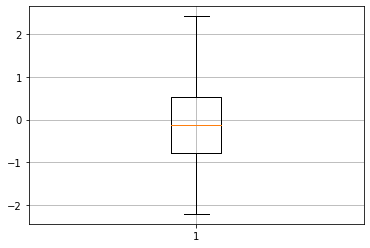

In [4]:
reds = np.asarray(reds)
plt.boxplot(reds)
plt.grid()
plt.show()